# 1. Set Up Notebook and Load Data 

In [6]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import fnmatch
import pickle
import ipywidgets as widgets
from IPython.display import display
import sys
import os
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Input, Flatten, Dense, Conv2DTranspose, LeakyReLU, BatchNormalization,  LeakyReLU,  Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import elu
from tensorflow.keras.initializers import HeUniform, GlorotUniform, HeNormal
from keras.regularizers import l2, l1
# from sklearn.metrics import mean_squared_error
tf.config.list_physical_devices('GPU')

# CUSTOM Imports
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Num GPUs Available:  1
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.0


Dropdown(description='Set :', index=1, options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='All')

In [9]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist2D*24*minmax*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

Dropdown(description='TSNE File :', options=('hist2D-All-nE16-nt24-normminmax.pkl',), value='hist2D-All-nE16-n…

In [10]:
# Load features
input_file = input_widget.value
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
ids = list(hist_dict.keys())
histograms = hist_dict.values()
features = np.array([np.array(h) for h in histograms])
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-All.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index(drop=True)
# Labels
df_label = df_properties.copy()
df_label = df_label[['obsreg_id','hard_hs', 'hard_hm','hard_ms']]
mask_nonan = df_label.notna().all(axis=1)
index_nonan = list(df_label.notna().all(axis=1).index[df_label.notna().all(axis=1)])
df_label = df_label[mask_nonan]
ID = df_label['obsreg_id'].values
hr_hs = np.array(df_label['hard_hs'].values)
hr_hm = np.array(df_label['hard_hm'].values)
hr_ms = np.array(df_label['hard_ms'].values)
y = np.vstack((hr_hs, hr_hm, hr_ms)).T
# Features
X = np.array([features[i] for i in index_nonan])
# X = np.array([features[i].flatten() for i in index_nonan])
# x = tf.expand_dims(X, 3)
X_train, X_test, y_train, y_test, ID_train, ID_test = train_test_split(X, y, ID, test_size=0.1, random_state=42)
# x_train = tf.expand_dims(X_train, 3)
# x_test = tf.expand_dims(X_test, 3)
# Print Summary
print ('Training Set', X_train.shape)
print ('Training Labels', y_train.shape)
print ('Test Set', X_test.shape)
print ('Test Labels', y_test.shape)
# print ('Input Shape ', input_shape)


Training Set (72796, 24, 16)
Training Labels (72796, 3)
Test Set (8089, 24, 16)
Test Labels (8089, 3)


# 3. Model

In [5]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Define the Multitask MLP model
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=input_shape)) 
model.add(Dense(16, activation='relu')) 
model.add(Dense(output_shape)) 

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stopping])

# Evaluate the model on the testing data
y_pred = np.clip(model.predict(X_test),-1,1)
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/50


2023-05-07 15:43:50.171071: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


InternalError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/Users/steven/tensorflow-test/env/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/steven/tensorflow-test/env/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/steven/tensorflow-test/env/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/steven/tensorflow-test/env/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/steven/tensorflow-test/env/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/q1/jbx7qj7s0dxbh7nv02nfvc680000gn/T/ipykernel_1546/3592602564.py", line 17, in <module>
      model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stopping])
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/losses.py", line 1470, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Invalid input shapes
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_train_function_858]

In [13]:
# Define Model Settings
input_shape = (24, 16, 1)
activation = 'relu' # LeakyReLU(alpha=0.1) # 'selu' # LeakyReLU(alpha=0.2)
kernel_init = 'he_normal' #HeNormal(seed=1) #glorot_uniform' #'he_normal' #'glorot_uniform'
# Define regressor
model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation, kernel_initializer= kernel_init, padding='same', input_shape=input_shape)) 
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation=activation, kernel_initializer= kernel_init, padding='same')) 
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation=activation, kernel_initializer= kernel_init))
model.add(Dense(32, activation=activation, kernel_initializer= kernel_init))
model.add(Dense(y_train.shape[1],activation='linear'))
# Training Set Up
lr = 0.001
optimizer = Adam(learning_rate = lr)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1)
loss_function = 'mse'
model.compile(optimizer=optimizer, loss=loss_function)
model.summary()
# Training 
name = input('Name: ')
epochs = 250
batch = 64
history = model.fit(X_train, y_train, epochs=epochs,batch_size=batch,shuffle=True,validation_data=(X_test, y_test),callbacks=[early_stopping]) # 128 or 256, 512, 1024, 2048, 4096
# Saving
model.save(f'{global_path}/{set_id}/HR-2D-CNN-a{activation}-lr{lr}-e{epochs}-b{batch}-{name}.h5')
with open(f'{global_path}/{set_id}/HR-HISTORY-2D-CNN-a{activation}-lr{lr}-e{epochs}-b{batch}-{name}.pickle', 'wb') as file:
    pickle.dump(history.history, file)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 16, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 8, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 8, 64)         18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 dense_9 (Dense)             (None, 64)               

KeyboardInterrupt: 

In [16]:
# Select saved model
files = os.listdir(f'{global_path}/{set_id}/')

# Saving
model.save(f'{global_path}/{set_id}/HR-2D-CNN-a{activation}-lr{lr}-e{epochs}-b{batch}-{name}.h5')
with open(f'{global_path}/{set_id}/HR-HISTORY-2D-CNN-a{activation}-lr{lr}-e{epochs}-b{batch}-{name}.pickle', 'wb') as file:
    pickle.dump(history.history, file)

hr_files = [f for f in files if fnmatch.fnmatch(f, 'HR*CNN*')]
hist_files = [f for f in files if fnmatch.fnmatch(f, '*HR-HISTORY*FC*')]
hr_widget = widgets.Dropdown(options=hr_files[:],value=hr_files[-1],description='Autoencoder :',disabled=False,style = {'description_width': 'initial'}); hr_widget 
hist_widget = widgets.Dropdown(options=hist_files[:],value=hist_files[-1],description='History :',disabled=False,style = {'description_width': 'initial'}); hist_widget 
layout = widgets.HBox([hr_widget, hist_widget])
display(layout)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 384)               0         
                                                                 
 bottleneck (Dense)          (None, 48)                18480     
                                                                 
 dense_6 (Dense)             (None, 384)               18816     
                                                                 
 reshape_2 (Reshape)         (None, 24, 16)            0         
                                                                 
Total params: 37,296
Trainable params: 37,296
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2_input (InputLayer  [(N

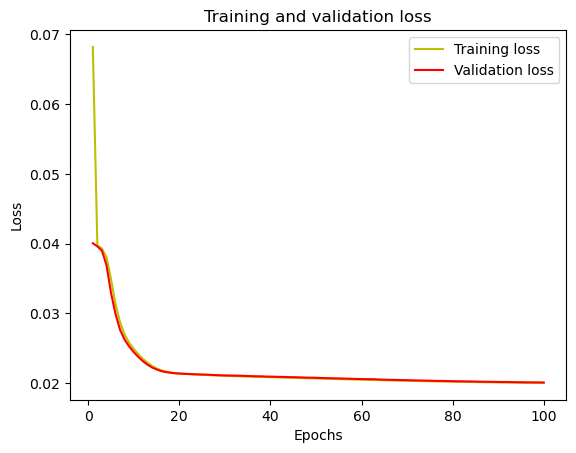

In [17]:
# Load the selected saved model 
ac = ac_widget.value
h = hist_widget.value
e = encode_widget.value
model = tf.keras.models.load_model(f'{global_path}/{set_id}/{ac}')
encoder_model = tf.keras.models.load_model(f'{global_path}/{set_id}/{e}')
model.summary()
encoder_model.summary()
with open(f'{global_path}/{set_id}/{h}', 'rb') as file:
    summary = pickle.load(file)
#plot the training and validation accuracy and loss at each epoch
loss = summary['loss']
val_loss = summary['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
test_loss = model.evaluate(X_test, X_test)

# Print the test loss
print(f'Test loss: {test_loss:.4f}') #0.0088 yuri

299/299 [==============================] - 1s 3ms/step - loss: 0.0247
Test loss: 0.0247


In [10]:
reconstructions = model.predict(X)
embedding = encoder_model.predict(X)

2984/2984 [==============================] - 3s 871us/step


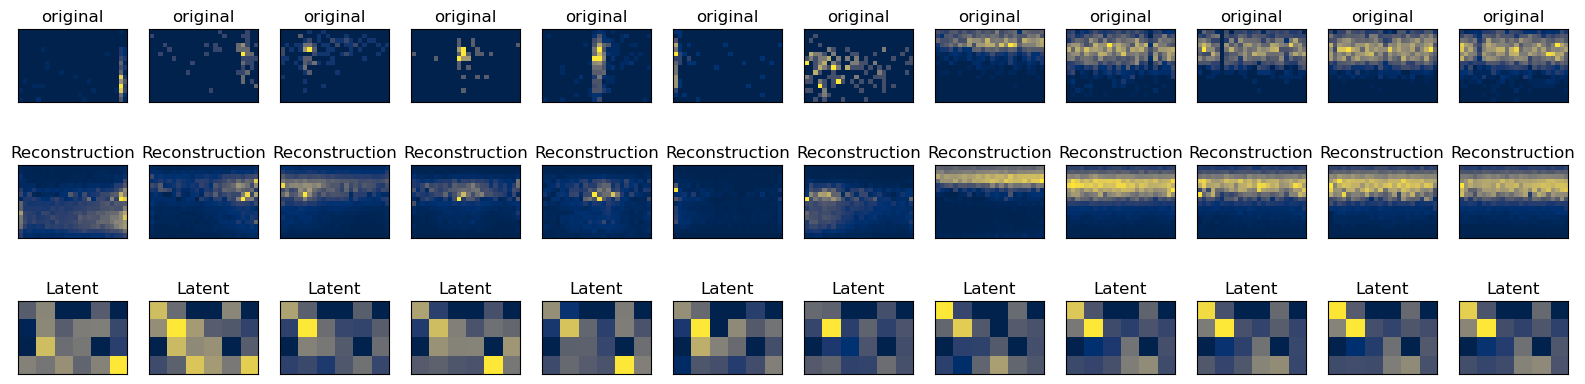

In [18]:
import random
# filtered_ids = [id for id in ids if id.split('_')[1] == '10'][10:20]
#####SELECTED ANOMALIES
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218']
# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']
ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']
# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
xue = ['957_208', '3389_274','15211_38']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59']
vasquez = ['2025_39','9548_14','15113_59']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015
flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']
NEW = ['23022_122']
ran = random.randint(0, 95000)
r = ids[ran:ran+10]
items_to_find = NEW + xue + lin + distefano + parmar 
# items_to_find = r
# Using a list comprehension to find indices of items in the other list
indices = [ids.index(item) for item in items_to_find]

n = len(indices)
plt.figure(figsize=(20, 5))
top = 40
k = 0 

for i in indices:
  k = k+1
  # display original
  ax = plt.subplot(3, n, k)
  plt.imshow(X[i].T,cmap='cividis')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, k+n)
  plt.imshow(reconstructions[i].T,cmap='cividis')
  plt.title(f'Reconstruction')
  # plt.title(f'R: {rec_err[i]:.3f}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display encoded results
  ax = plt.subplot(3, n, k+n+n)
  plt.imshow(embedding[i].reshape((6,4)).T,cmap='cividis')
  plt.title(f'Latent')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

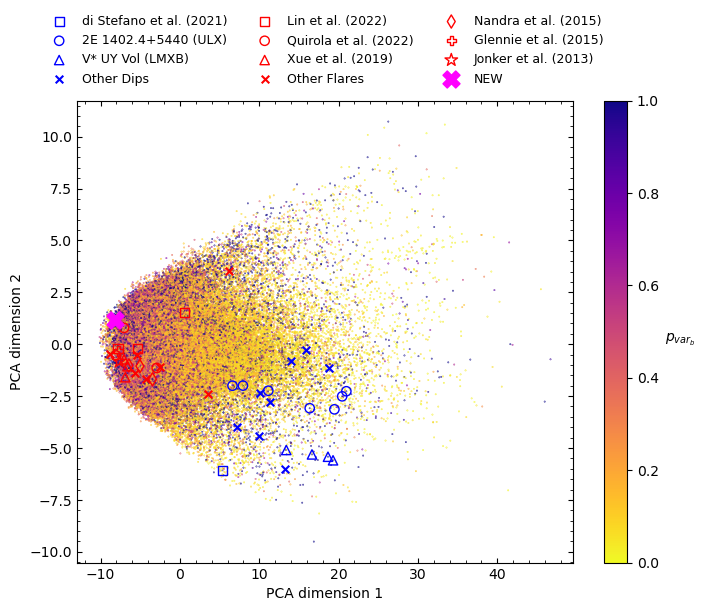

In [19]:
# PCA
from sklearn.decomposition import PCA
pca_model = PCA(2)
X_pca = pca_model.fit_transform(embedding) 
df_pca = pd.DataFrame(X_pca, columns=['1', '2'])
df_pca['obsreg_id'] = ID


pca_lin = df_pca.loc[df_pca['obsreg_id'].isin(lin)]
pca_irwin = df_pca.loc[df_pca['obsreg_id'].isin(irwin)]
pca_glennie = df_pca.loc[df_pca['obsreg_id'].isin(glennie)]
pca_jonker = df_pca.loc[df_pca['obsreg_id'].isin(jonker)]
pca_vasquez = df_pca.loc[df_pca['obsreg_id'].isin(vasquez)]
pca_xue = df_pca.loc[df_pca['obsreg_id'].isin(xue)]
pca_goulding = df_pca.loc[df_pca['obsreg_id'].isin(goulding)]
pca_nandra = df_pca.loc[df_pca['obsreg_id'].isin(nandra)]
pca_flares = df_pca.loc[df_pca['obsreg_id'].isin(flares + flares_maybe)]

pca_m101ulx = df_pca.loc[df_pca['obsreg_id'].isin(m101ulx)]
pca_distefano = df_pca.loc[df_pca['obsreg_id'].isin(distefano)]
pca_moredips = df_pca.loc[df_pca['obsreg_id'].isin(ieva + dips_maybe)]
pca_parmar = df_pca.loc[df_pca['obsreg_id'].isin(parmar)] # LMXB

pca_new = df_pca.loc[df_pca['obsreg_id'].isin(NEW)] 

fig, axs = plt.subplots(figsize=(8, 6))
var_b = axs.scatter(df_pca['1'], df_pca['2'],c=df_label['var_prob_b'], s=0.1, cmap='plasma_r')
axs.set_xlabel('PCA dimension 1')
axs.set_ylabel('PCA dimension 2')
axs.grid(False) 
cbar = axs.figure.colorbar(var_b, ax=axs)
cbar.ax.set_ylabel(r'$p_{var_b}$', rotation = 0,labelpad=15)
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)

c_d = 'blue'
c_f = 'red'
markersize = 30

axs.scatter(pca_distefano['1'], pca_distefano['2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(pca_m101ulx['1'], pca_m101ulx['2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(pca_parmar['1'], pca_parmar['2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(pca_moredips['1'], pca_moredips['2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
axs.scatter(pca_lin['1'], pca_lin['2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(pca_vasquez['1'], pca_vasquez['2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Quirola et al. (2022)')
axs.scatter(pca_xue['1'], pca_xue['2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(pca_flares['1'], pca_flares['2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(pca_nandra['1'], pca_nandra['2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(pca_glennie['1'], pca_glennie['2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(pca_jonker['1'], pca_jonker['2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')

axs.scatter(pca_new['1'], pca_new['2'], c='magenta', marker='X', s=markersize*5, facecolor='none', label='NEW')

axs.grid(False) 
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
anomaly_legend = axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),
          ncol=3, frameon = False,fontsize=9)